<b>Training overview</b>

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 6.4 MB/s 
     |████████████████████████████████| 4.0 MB 43.9 MB/s 
     |████████████████████████████████| 1.2 MB 41.8 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 46.8 MB/s 
     |████████████████████████████████| 880 kB 49.2 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=4e3e06604373a68a3555ad743a87c0cdb9c5f6f477f04518a275edb45d0daf93
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=e250beda7677592329e0e8bdddb678e052a426d312b0176fe8be0ad1df038e8e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sentence_transformers import SentenceTransformer, models, util
import nltk
nltk.download('punkt')
import glob
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tqdm.notebook import tqdm_notebook
import pickle

In [ ]:
l_sents= []
sents = set()
for filename in tqdm_notebook(glob.glob(f'/content/drive/My Drive/corpus/*.txt')):
    sents = set()
    with open(filename, 'r', encoding="utf8", errors='ignore') as in_file: 
        text = in_file.read().replace('\n', ' ')
    sents |= set(nltk.sent_tokenize(text))
    sents = list(sents)
    _, tail = os.path.split(filename)
    auth = tail.split("_")[0]
    l_sents.append((auth,sents,tail))

l_sents = list(l_sents)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
from os.path import exists

PATH = '/content/drive/My Drive/encodings/'
embeddings_l = []
authors_d = {}
authors_l = []
for i in tqdm_notebook(l_sents):
    filename = PATH + i[2] + '.pickle'
    if exists(filename): # load
        with open(filename, 'rb') as f:
            embeddings = pickle.load(f)
    else: # calculate and save
        embeddings = model.encode(i[1])
        with open(filename, 'wb') as f:
            pickle.dump(embeddings, f, pickle.HIGHEST_PROTOCOL)
    embeddings_l.append(embeddings)
    if not i[0] in authors_d:
        authors_d[i[0]] = len(authors_d)
    authors_l.append(authors_d[i[0]])


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
embeddings_l[0].shape

(4487, 384)

In [ ]:
import numpy as np

In [ ]:
sum = []
avg = []
for lists in embeddings_l:
    sum.append(np.sum(lists, axis=0))  
    avg.append(np.average(lists, axis=0))

In [ ]:
from sklearn import svm
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
words_df = pd.DataFrame(sum)

In [ ]:
X_eb = TSNE(n_components=3, learning_rate='auto',init='pca').fit_transform(words_df)
X_eb.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(100, 3)

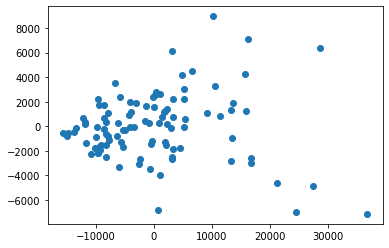

In [ ]:
label = [i for i in range(X_eb.shape[0])]
plt.scatter(X_eb[:,0], X_eb[:,1], label=label)
plt.show()

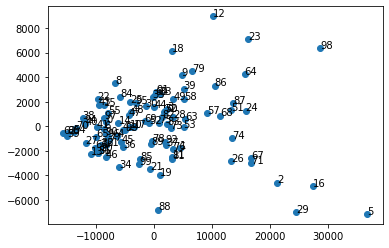

In [ ]:
plt.scatter(X_eb[:,0], X_eb[:,1])
for i in range(X_eb.shape[0]):
    plt.text(X_eb[i,0], X_eb[i,1], f"{label[i]}")

**k-NN Classification**

In [ ]:
embeddings_l2 = []
for idx, tmp in enumerate(embeddings_l):
    embeddings_l2.append(np.insert(tmp, 0, authors_l[idx], axis=1))
embeddings_l2 = np.concatenate(embeddings_l2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(avg, authors_l, test_size=0.20)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(avg)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 0.82845401, -0.85320419,  0.8509882 , ...,  0.58047284,
         0.40461474, -0.23726101],
       [ 1.63761416, -1.20425167,  1.09766966, ...,  1.20964285,
         1.39441823, -0.25218085],
       [ 0.7583728 , -0.2066948 , -0.48411086, ...,  0.1800031 ,
        -0.11146474,  0.65888562],
       ...,
       [-0.93474387,  1.2446188 , -2.35033521, ..., -1.27737809,
        -1.11535058, -0.09586168],
       [ 0.95555913,  0.11056107,  1.15085652, ..., -0.16021126,
        -0.74856093, -1.67099227],
       [ 0.54359177, -1.34949107,  0.35425735, ...,  0.20816575,
         1.02955319, -0.02222923]])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
error_rate = []
for i in range(1,80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Minimum error:- 0.5 at K = 0


In [ ]:
acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))

print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

Maximum accuracy:- 0.5 at K = 0


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

**Neural Network**


In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
import random

In [ ]:
#NUMBER = min(map(len, embeddings_l))
#sample = map(lambda x: random.sample(list(x), NUMBER), embeddings_l)
#x = tf.data.Dataset.from_tensor_slices(list(sample))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_l2[:,1:], embeddings_l2[:,0], test_size=0.20)
#X_train = x.take(80)
#X_test = x.skip(80)

#y_train = tf.data.Dataset.from_tensor_slices(list(map(lambda x: tf.convert_to_tensor(x),authors_l[:80])))
#y_test = tf.data.Dataset.from_tensor_slices(list(map(lambda x: tf.convert_to_tensor(x),authors_l[80:100])))

In [ ]:
y_train.shape

(629104,)

In [ ]:
X_train.shape

(629104, 384)

In [ ]:
from keras.models import Sequential
from keras import Input, Model
from keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, Reshape

'''
nn_model = Sequential()
#nn_model.add(Input(shape=(None,384,1)))
nn_model.add(Input(shape=(None,384)))
nn_model.add(Conv1D(filters=48, kernel_size=3, strides=1, activation="relu"))
nn_model.add(MaxPooling1D(pool_size=2, strides=4))
nn_model.add(Dense(len(authors_d)))
nn_model.compile(loss='binary_crossentropy',metrics=['accuracy'])
nn_model.summary()
'''

_inputs = Input(shape=(100, None, 384), batch_size=1)
_outputs = _inputs
#_outputs = Reshape((384,1))(_outputs)
_outputs = Conv2D(filters=20, kernel_size=3, activation="relu")(_outputs)
_outputs = MaxPooling2D(pool_size=(4,4), strides=4)(_outputs)
_outputs = Dense(len(authors_d))(_outputs)
nn_model = Model(inputs=_inputs, outputs=_outputs)
nn_model.compile(loss='binary_crossentropy',metrics=['accuracy'])
nn_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(1, 100, None, 384)]     0         
                                                                 
 conv2d_4 (Conv2D)           (1, 98, None, 20)         69140     
                                                                 
 max_pooling2d_3 (MaxPooling  (1, 24, None, 20)        0         
 2D)                                                             
                                                                 
 dense_11 (Dense)            (1, 24, None, 34)         714       
                                                                 
Total params: 69,854
Trainable params: 69,854
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = nn_model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False)
loss, accuracy = nn_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


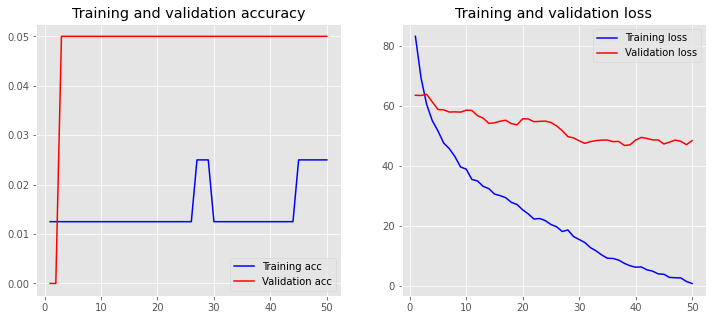

In [ ]:
plot_history(history)

In [ ]:
import tensorflow as tf
# Define Sequential model with 3 layers
mmodel = keras.Sequential(
    [   Input(shape=(None, 3)),
        Dense(2, activation="relu", name="layer1"),
        #Dense(3, activation="relu", name="layer2"),
        #Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = mmodel(x)
y

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>